In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
df_test = pd.read_csv(test_csv_path, sep=",")
df_test["img_path"] =  df_test['image_id'].apply(build_image_path, convert_dtype=str)

In [25]:
# clean_all_datasets()

# Criando os diretórios:
# create_dataset_dirs()
    
# Criando os subdiretórios
# build_train_dataset_from_ori_imgs(df_train_split)
    
# build_val_dataset_from_ori_imgs(df_val_split)

build_test_dataset_from_ori_imgs(df_test)

In [26]:
# Criando geradores de imagem para o tensorflow:

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [27]:
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir_path,
    # classes = class_names,
    target_size = target_size,
    batch_size = 64,
    class_mode = 'binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir_path,
        # classes = class_names,
        target_size = target_size,
        batch_size = 64,
        class_mode = 'binary',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        test_dir_path,
        # classes = class_names,
        target_size = target_size,
        batch_size = 64,
        class_mode = 'binary')

Found 11410 images belonging to 2 classes.
Found 2852 images belonging to 2 classes.
Found 10962 images belonging to 2 classes.


/tmp/ipykernel_42250/3629864925.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i + 1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for

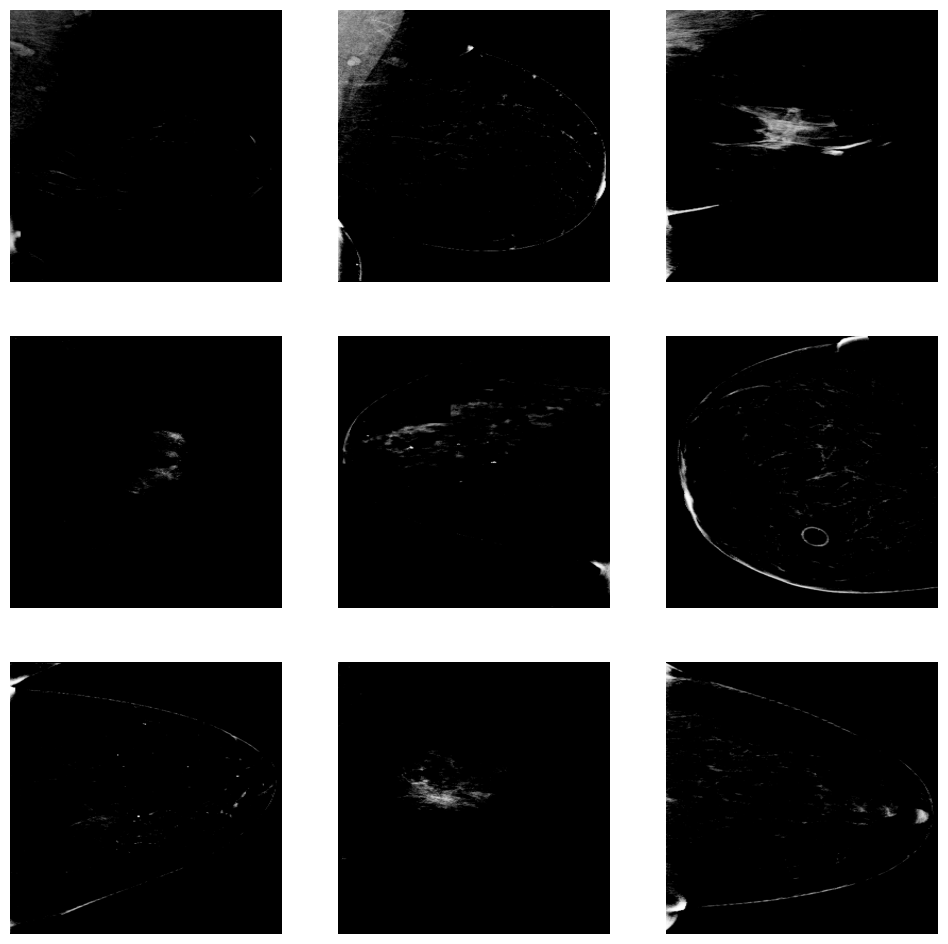

In [28]:
def plot_images(dataset):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    images, labels = next(dataset)
    axes = axes.ravel()
    for i in range(9):
      image = images[i]
      # print_img_props(image)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image, cmap='gray')
      plt.axis("off")
    
plot_images(train_generator)

In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

model_resnet50 = ResNet50V2(weights = 'imagenet', input_shape = (target_size[0], target_size[1], 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False
    
# build the entire model
x = model_resnet50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_resnet50.input, outputs = predictions)

model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [30]:
%load_ext tensorboard
from datetime import datetime

logs_dir = '/home/kasco/MDC/FinalProject/BreastCancerDetection/logs/resnet_sgd_lr_00001'

logdir = os.path.join(logs_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
from keras.optimizers import SGD, Adam

early_stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 20, )
save_model = tf.keras.callbacks.ModelCheckpoint(filepath = '../weights/resnet_sgd_lr_00001/weights.{epoch:02d}-{val_loss:.2f}.h5', monitor = "val_loss", mode = "min", save_best_only = True)

# define training function
def trainModel(model, epochs, optimizer, callbacks = []):
    batch_size = 64
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator,
                     validation_data=validation_generator,
                      epochs=epochs,
                      steps_per_epoch = train_generator.samples // batch_size,
                      validation_steps = validation_generator.samples // batch_size,
                      batch_size=batch_size,
                      callbacks=callbacks)

sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
adam =  Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_history = trainModel(model = model, epochs = 500, optimizer = sgd, callbacks = [early_stopper, save_model, tensorboard_callback])

/home/kasco/anaconda3/envs/mdc-tf-gpu/lib/python3.9/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/kasco/anaconda3/envs/mdc-tf-gpu/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/500


2023-07-04 09:17:05.494389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


178/178 [==============================] - ETA: 0s - loss: 0.8452 - accuracy: 0.5040

2023-07-04 09:18:52.602607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


178/178 [==============================] - 133s 742ms/step - loss: 0.8452 - accuracy: 0.5040 - val_loss: 0.7119 - val_accuracy: 0.4734
Epoch 2/500
178/178 [==============================] - 129s 726ms/step - loss: 0.8330 - accuracy: 0.4930 - val_loss: 0.7104 - val_accuracy: 0.4773
Epoch 3/500
178/178 [==============================] - 133s 742ms/step - loss: 0.8164 - accuracy: 0.5018 - val_loss: 0.7091 - val_accuracy: 0.4773
Epoch 4/500
178/178 [==============================] - 110s 617ms/step - loss: 0.8042 - accuracy: 0.4936 - val_loss: 0.7072 - val_accuracy: 0.4762
Epoch 5/500
178/178 [==============================] - 110s 617ms/step - loss: 0.7935 - accuracy: 0.4981 - val_loss: 0.7062 - val_accuracy: 0.4773
Epoch 6/500
178/178 [==============================] - 110s 615ms/step - loss: 0.7829 - accuracy: 0.5035 - val_loss: 0.7052 - val_accuracy: 0.4759
Epoch 7/500
178/178 [==============================] - 110s 619ms/step - loss: 0.7859 - accuracy: 0.5046 - val_loss: 0.7041 - val_

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

NameError: name 'model_history' is not defined

Text(0, 0.5, 'loss')

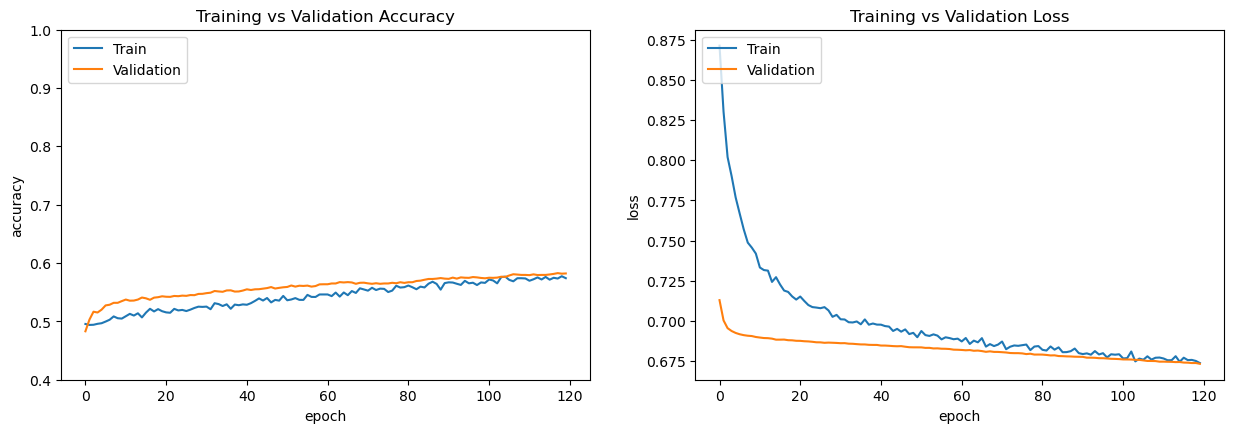

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

2023-07-03 23:21:55.083696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


172/172 [==============================] - 97s 560ms/step


Text(50.722222222222214, 0.5, 'Real')

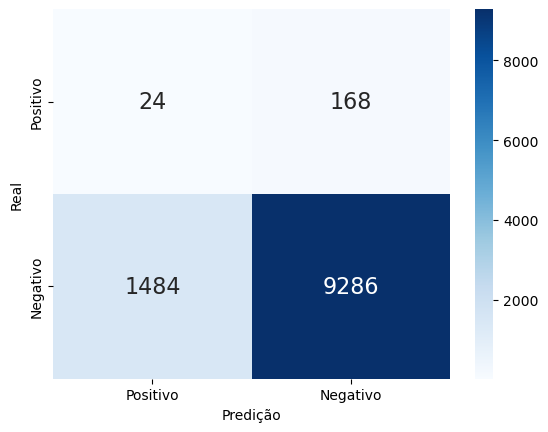

In [ ]:
model_resnet50 = load_model('augmentation_resnet50.h5')

pred_resnet50 = model_resnet50.predict(test_generator)

y_pred_resnet50 = []
for prob in pred_resnet50:
    if prob >= 0.5:
        y_pred_resnet50.append(1)
    else:
        y_pred_resnet50.append(0)
        
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_resnet50)

class_names = ['Positivo', 'Negativo']

ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

ax.set_xlabel("Predição")
ax.set_ylabel("Real")